In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from os import path
from sklearn import discriminant_analysis

In [2]:
_HOME_ = path.expanduser("~") + "/PHD"

In [3]:
cluster_indices = pd.read_excel(_HOME_ + "/ISPRA_20152017_Analysis/Clustering/Unknown_effect/cluster_indices.xlsx", sheet_name="method_2", index_col=[0,1])

In [4]:
env_long = pd.read_csv(_HOME_ + "/ISPRA_20152017_Analysis/Create_dataset/df_chem_phys_mod_data_cleaned_long_format.csv", index_col=[2, 1])
env_long.index = pd.MultiIndex.from_tuples([(pd.to_datetime(date),id) for date, id in env_long.index], names=["Date", "id"])

In [9]:
features = [
    "T", 
    "Salinity", 
    "O_sat", 
    "pH", 
    "Chla", 
    "NO3", 
    "NO2", 
    "NH4", 
    "TN", 
    "PO4", 
    "TP", 
    "SiO4"
]

<Axes: >

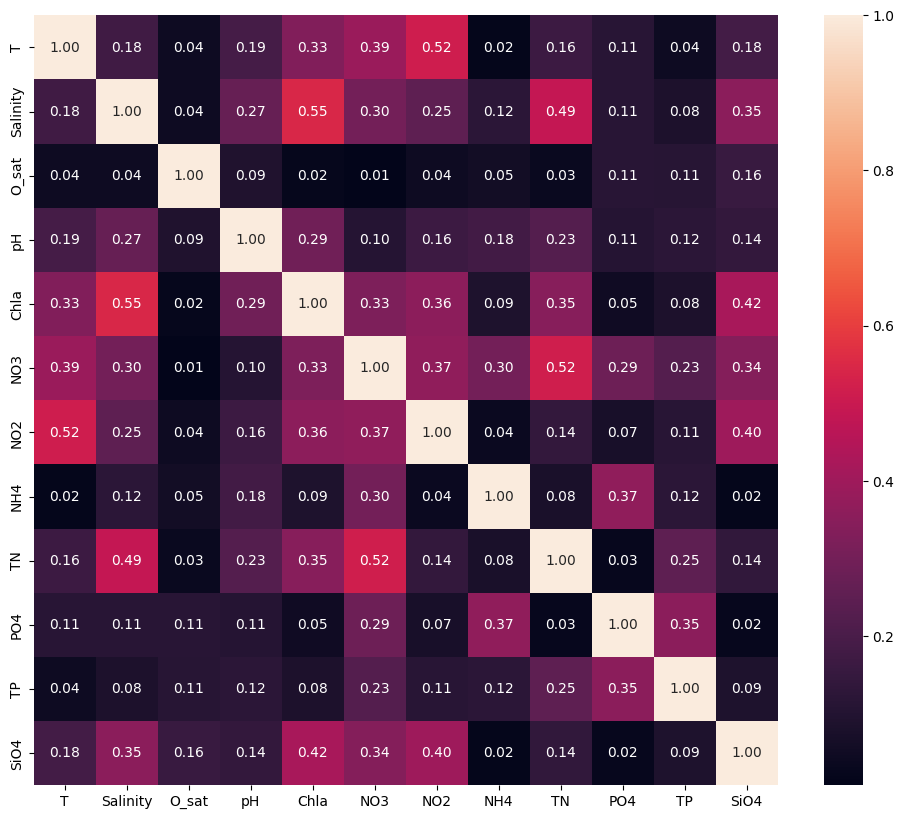

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
sns.heatmap(
    np.abs(env_long.loc[:, features].corr("spearman")), 
    annot=True,
    fmt=".2f",
    ax=ax
)

In [10]:
env_long.isna().sum(axis = 0).sort_values(ascending=False)

Secchi_depth    436
NO2             333
PO4             261
TP              240
NH4             233
NO3             213
TN              139
Salinity        125
SiO4            111
Chla            106
O_sat            69
DO               67
pH               61
E_cond           55
T                48
Region            0
dtype: int64

In [75]:
training_data = env_long.loc[:, features].merge(cluster_indices.loc[:, ["ward_4", "ward_11"]], left_index=True, right_index=True, how = "inner").dropna()

In [12]:
cluster_indices.groupby("ward_4").agg({"ward_11" : "count"}).rename(columns={"ward_11": "Chla"})

,Chla
ward_4,
1,385
2,189
3,62
4,1537


In [14]:
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import pdist, squareform
import skbio

In [76]:
nutrients = [
    "Chla", 
    "NO3", 
    "NO2", 
    "NH4", 
    "TN", 
    "PO4", 
    "TP", 
    "SiO4"
]

In [77]:
training_data.loc[:, nutrients] = training_data.loc[:, nutrients].apply(lambda x: np.log10(x + 1))

In [78]:
training_data.loc[:, features] = StandardScaler().fit_transform(training_data.loc[:, features])

In [19]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [83]:
LDAs = {
    "ward_4": LinearDiscriminantAnalysis(n_components=2),
    "ward_11": LinearDiscriminantAnalysis(n_components=2)
}
projections = {}

In [84]:
for clustering in LDAs.keys():
    LDAs[clustering].fit(training_data.loc[:, features].values, training_data.loc[:, clustering].to_numpy());
    projected_points =  LDAs[clustering].transform(training_data.loc[:, features].values)
    projections[clustering] =  pd.DataFrame(
        {
            "LDA1" : projected_points[:, 0],
            "LDA2" : projected_points[:, 1],
            "Cluster" : training_data.loc[:, clustering].to_list()
        }
    )

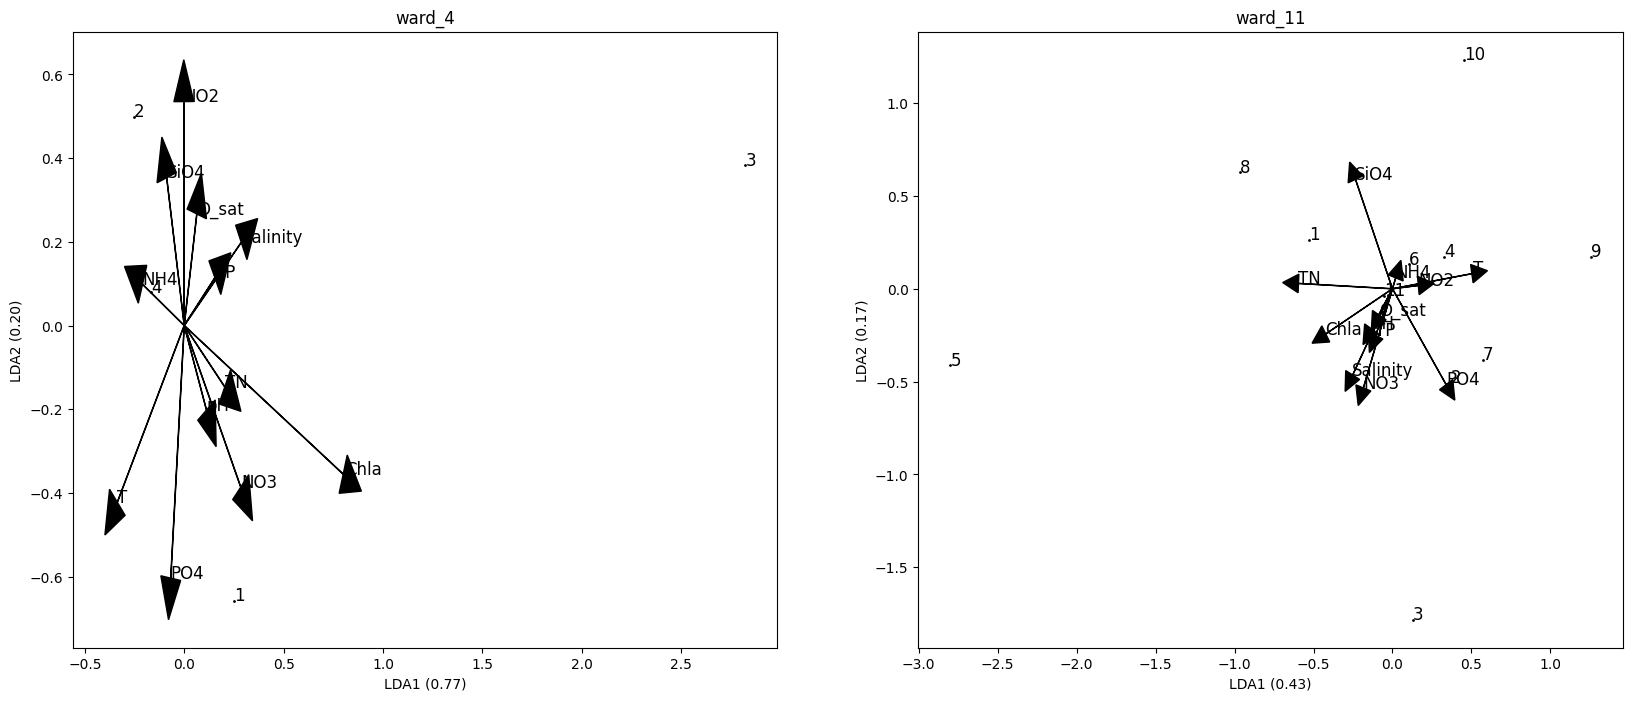

In [112]:
fig, axs = plt.subplots(1, 2, figsize=(20, 8))
axs = axs.flatten()
for clustering, ax in zip(LDAs.keys(), axs):
    #sns.scatterplot(
    #    x="LDA1",
    #    y="LDA2",
    #    hue="Cluster",
    #    data=projections[clustering],
    #    palette=sns.palettes.color_palette("tab20", n_colors=projections[clustering].Cluster.unique().size),
    #    ax=ax
    #)

    for feature_scaling, fueature_name in zip(LDAs[clustering].scalings_[:, :2], features):
        ax.arrow(0, 0, feature_scaling[0], feature_scaling[1], head_width=0.1, head_length=0.1, fc='k', ec='k')
        ax.text(feature_scaling[0] * (1 + 0.01), feature_scaling[1] , fueature_name, fontsize=12)
    
    ax.scatter(*LDAs[clustering].transform(LDAs[clustering].means_).T, c="black", s=1)

    for cluster_mean, cluster in zip(LDAs[clustering].transform(LDAs[clustering].means_), LDAs[clustering].classes_):
        ax.text(cluster_mean[0], cluster_mean[1], cluster, fontsize=12)

    

    ax.set_title(clustering)
    ax.set_xlabel(f"LDA1 ({LDAs[clustering].explained_variance_ratio_[0]:.2f})")
    ax.set_ylabel(f"LDA2 ({LDAs[clustering].explained_variance_ratio_[1]:.2f})")

In [93]:
projections["ward_4"].groupby("Cluster").agg({"LDA1": "mean", "LDA2": "mean"})

,LDA1,LDA2
Cluster,,
1,0.249226,-0.657837
2,-0.254017,0.498866
3,2.823081,0.383386
4,-0.165640,0.079389


In [108]:
LDAs["ward_11"].transform(LDAs["ward_11"].means_)

array([[-0.52886324,  0.26414733],
       [ 0.37084804, -0.50270991],
       [ 0.13062752, -1.782235  ],
       [ 0.32571368,  0.17263148],
       [-2.79965102, -0.41089454],
       [ 0.10547319,  0.13392914],
       [ 0.57146897, -0.38268506],
       [-0.9684682 ,  0.62625613],
       [ 1.25661086,  0.17193375],
       [ 0.4527681 ,  1.23353168],
       [-0.05322254, -0.03775205]])

In [107]:
for cluster_mean, cluster in zip(LDAs[clustering].transform(LDAs[clustering].means_), LDAs[clustering].classes_):
    print(cluster_mean, cluster)

[-0.52886324  0.26414733] 1
[ 0.37084804 -0.50270991] 2
[ 0.13062752 -1.782235  ] 3
[0.32571368 0.17263148] 4
[-2.79965102 -0.41089454] 5
[0.10547319 0.13392914] 6
[ 0.57146897 -0.38268506] 7
[-0.9684682   0.62625613] 8
[1.25661086 0.17193375] 9
[0.4527681  1.23353168] 10
[-0.05322254 -0.03775205] 11


In [101]:
training_data.groupby("ward_4").agg("mean")

,T,Salinity,O_sat,pH,Chla,NO3,NO2,NH4,TN,PO4,TP,SiO4,ward_11
ward_4,,,,,,,,,,,,,
1,0.139156,-0.183578,0.054542,0.203821,0.229951,0.229933,-0.172323,0.030153,0.306419,0.350174,0.194068,-0.119411,1.738956
2,-0.009274,0.405000,-0.098917,-0.188733,-0.276679,-0.501880,0.102629,-0.287777,-0.314895,-0.225727,-0.097514,-0.246641,4.000000
3,-1.679076,-1.324606,0.812708,1.035236,2.132179,1.509916,1.629567,-0.509808,1.252415,-0.267810,0.417821,1.196643,5.000000
4,0.052947,0.075141,-0.043085,-0.076831,-0.128463,-0.087414,-0.049327,0.033417,-0.099626,-0.041381,-0.050908,-0.020539,8.852719


In [127]:
training_data.to_csv(_HOME_ + "/ISPRA_20152017_Analysis/Clustering/Unknown_effect/training_data_LDA.csv")

In [66]:
LDAs["ward_11"].means_[:, :2]

array([[19.60494975, 35.75278636],
       [21.48287812, 36.97291172],
       [19.16728819, 37.853745  ],
       [19.17364952, 37.9864319 ],
       [10.0780172 , 33.83185685],
       [18.63916104, 37.73388685],
       [21.12771994, 38.09897139],
       [16.97761293, 35.60209556],
       [21.72414931, 38.0564131 ],
       [24.42201858, 35.88968663],
       [19.10142236, 36.84605344]])

In [68]:
projections["ward_11"]

,LDA1,LDA2,Cluster
0,1.276206,0.503502,11
1,0.983611,-0.025538,2
2,0.888643,-0.474090,11
3,0.280094,-0.578693,5
4,-0.359449,-1.211429,11
...,...,...,...
1700,-0.351657,0.008940,4
1701,0.565172,1.708961,11
1702,1.261696,0.396960,1
1703,0.598815,0.267316,1


In [61]:
training_data.groupby("ward_4").agg("count")

,T,Salinity,O_sat,pH,Chla,NO3,NO2,NH4,TN,PO4,TP,SiO4,ward_11
ward_4,,,,,,,,,,,,,
1,249,249,249,249,249,249,249,249,249,249,249,249,249
2,70,70,70,70,70,70,70,70,70,70,70,70,70
3,62,62,62,62,62,62,62,62,62,62,62,62,62
4,1324,1324,1324,1324,1324,1324,1324,1324,1324,1324,1324,1324,1324


In [64]:
np.linalg.norm(LDAs["ward_4"].scalings_, axis = 0)

array([1.07239569, 1.29250983, 1.34876543])

In [70]:
LDAs["ward_4"].means_

array([[ 0.14472852, -0.15625701,  0.04261264,  0.18553301,  0.21327621,
         0.23824857, -0.26988006, -0.01239301,  0.2396506 ,  0.35900194,
         0.15394252, -0.12242985],
       [ 0.02238332,  0.42695678, -0.11330921, -0.2384502 , -0.28571559,
        -0.53466609,  0.34993061, -0.33776311, -0.47857408, -0.13886702,
         0.10866722, -0.31170881],
       [-1.65552385, -1.2688235 ,  0.78835841,  1.07247408,  2.08014289,
         1.4664433 ,  1.50281473, -0.72084475,  1.2979465 , -0.44317799,
         0.31931792,  1.17037398],
       [ 0.05343425,  0.07179274, -0.04217924, -0.07838674, -0.13240696,
        -0.09229348, -0.0414222 ,  0.05810229, -0.08719932, -0.04220329,
        -0.05340928, -0.01701971]])